In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
mpl.use("TkAgg")

from sklearn.preprocessing import normalize#, MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import h5py
import mne
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape, GRU, LSTM, Lambda, RepeatVector, Reshape, Dropout, Conv1D, UpSampling1D, Bidirectional

from os import walk, listdir


%matplotlib inline
data_path = "../../data/train/"
clear_data_path = "/media/valbub/Docs/data/train/"
raw_data_path = "../../data/resting_state/"

Using TensorFlow backend.


In [2]:
class AutoEncoder(object):
    def __init__(self, 
             input_dim = (5, 58), 
             encoded_dim = (1, 58), 
             loss="mse", 
             optimizer="adadelta", 
             activation=("relu", "sigmoid", "tanh", "elu"),
             act_idx=(0, 0),
             kernel = 3):
        
            self.input_dim = input_dim
            self.encoded_dim = encoded_dim
    
    def prepare_clear_data(self, data_path, limit=2):
        train_eeg_dir = data_path
        train_eeg_names = [x for x in listdir(train_eeg_dir) 
                         if x[-3:] == ".h5"]
        data = np.zeros((0, self.input_dim[0], self.input_dim[1]))

        flag = 0
        for eeg_name in train_eeg_names:
            if flag == limit:
                break
            flag += 1
            h5_file = h5py.File(train_eeg_dir + eeg_name, 'r')
            a_group_key = list(h5_file.keys())[0]
            eeg_data = np.array(h5_file[a_group_key]).T
            batches = np.array(self._getBatches(eeg_data, batch_size=self.input_dim[0]))
            if len(batches.shape) == 3:
                data = np.concatenate((data, batches), axis=0)
            else:
                print('-')
        return data
    
    def prepare_raw_data(self, data_path, limit=2):
        def preparefile(file_path):
            raw = np.array(mne.io.read_raw_brainvision(file_path, preload=True).to_data_frame())
            batches = np.array(self._getBatches(raw, batch_size=self.input_dim[0]))
            del raw
            return batches
        files = []
        data = []
        for elem in walk(data_path):
            for file in elem[-1]:
                if file[-4:] == "vhdr":
                    files.append(file)
        data = np.ndarray(shape=(0, self.input_dim[0], self.input_dim[1]))
        flag = 0
        for file in files:
            file_name = data_path + file
            if flag == limit:
                break
            batches =  preparefile(file_name)
            if len(batches.shape) == 3:
                data = np.concatenate((data, batches), axis=0)
            else:
                print('-')
            flag += 1
        return data
    
    def fit(self, X_train, epochs=50):
        X_scaled = self.scaler.fit_transform(X_train)
        return self.autoencoder.fit(X_scaled, X_scaled, epochs = epochs)
    
    def fit_scaler(self, X_train):
        self.scaler.fit_transform(X_train)
    
    def encode(self, df):
        return self._predict(df, self.encoder, self.input_dim[0])
    
    def decode(self, df):
        return self._predict(df, self.decoder, self.encoded_dim[1])
    
    def run(self, df):
        return self._predict(df, self.autoencoder, self.input_dim[0])
    
    def save(self, path, part="autoencoder"):
        if part == "encoder":
            self.encoder.save(path)
        elif part == "decoder":
            self.decoder.save(path)
        elif part == "autoencoder":
            self.autoencoder.save(path)
        pass
    
    def load(self, path, part="autoencoder", X_train=None):
        if part == "encoder":
            self.encoder = keras.models.load_model(path)
        elif part == "decoder":
            self.decoder = keras.models.load_model(path)
        elif part == "autoencoder":
            self.autoencoder = keras.models.load_model(path)
        if x_train is not None:
            self.fit_scaler(X_train)
    
    def _predict(self, df, model, batch_size):
        batches = self.scaler.transform(df)
        batches = tuple(self._predictBatch(batch.reshape((1, *batch.shape)), model) for batch in batches)
        batches = self._concatBatches(batches) 
        return self.scaler.reverse_transform(batches)
    
    def _predictBatch(self, batch, model):
        return model.predict(batch)
    
    def _getBatches(self, arr, batch_size, axis=0):
        n_batches = arr.shape[axis] // batch_size
        return np.array_split(arr, n_batches, axis=axis)
    
    def _concatBatches(self, batches, axis=0):
        return np.concatenate(batches, axis=axis)


In [3]:
class AU_Stage_3(AutoEncoder):
        def __init__(self, 
                 input_dim = (5, 58), 
                 encoded_dim = (1, 58), 
                 loss="mse", 
                 optimizer="adadelta", 
                 activation=("elu", "sigmoid"),
                 kernel = 3,
                 folds=50):
        
            self.input_dim = input_dim
            self.encoded_dim = encoded_dim

            #Encoder
            self._inputs = Input(shape=input_dim)
            self._lambda = Lambda(lambda x: K.round(x * folds) / folds)(self._inputs)
            self._lstm = LSTM(input_dim[1], return_sequences=True, dropout=0, recurrent_dropout=0.1)(self._lambda)
            self._conv = Conv1D(filters=encoded_dim[1], kernel_size=input_dim[0])(self._lstm)
            self._encoded = Dense(units=encoded_dim[1], activation=activation[0])(self._conv)
            
            #Decoder
            self._encoded_inputs = Input(shape=encoded_dim)
            self._flat_decoded_1 = Dense(units=np.prod(input_dim), activation=activation[1])(self._encoded_inputs)
            self._flat_decoded_2 = UpSampling1D(size=input_dim[0] // encoded_dim[0])(self._flat_decoded_1)
            self._lstm_2 = LSTM(input_dim[1], return_sequences=True)(self._flat_decoded_2)
            self._decoded = Reshape(input_dim)(self._lstm_2)
            
            #Models
            self.encoder = Model(self._inputs, self._encoded)
            self.decoder = Model(self._encoded_inputs, self._decoded)
            self.autoencoder = Model(self._inputs, self.decoder(self.encoder(self._inputs)))
            
            self.autoencoder.compile(optimizer=optimizer, loss=loss)
            
            class MinMaxScaler():

                def __init__(self, minimum=None, maximum=None):
                    self.minimum = minimum
                    self.maximum = maximum

                def fit_transform(self, X):
                    if self.minimum is None or self.maximum:
                        self.minimum = np.min(X, axis=(0, 1))
                        self.maximum = np.max(X, axis=(0, 1))  + 1e-10
                    return (X - self.minimum) / (self.maximum - self.minimum)

                def transform(self, X):
                    return (X - self.minimum) / (self.maximum - self.minimum)

                def reverse_transform(self, X_scl):
                    return X_scl * (self.maximum - self.minimum) + self.minimum

            self.scaler = MinMaxScaler()

In [4]:
limit = 14
epochs = 50

In [5]:
au = AU_Stage_3()
data_set = au.prepare_clear_data(clear_data_path, limit=limit)
data_set.shape

(1663700, 5, 58)

In [ ]:
hist = au.fit(data_set, epochs=epochs)

au.save("./modellstm_and_conv/au")
au.save("./modellstm_and_conv/en")
au.save("./modellstm_and_conv/de")
au.save("./modellstm_and_conv/class")

Epoch 1/50
1663700/1663700 [==============================] - 286s 172us/step - loss: 1.7954e-04
Epoch 3/50
1663700/1663700 [==============================] - 283s 170us/step - loss: 1.4771e-04
Epoch 4/50
1663700/1663700 [==============================] - 282s 170us/step - loss: 1.1465e-04
Epoch 5/50
1663700/1663700 [==============================] - 283s 170us/step - loss: 1.0650e-04
Epoch 6/50
1663700/1663700 [==============================] - 283s 170us/step - loss: 1.0387e-04
Epoch 7/50
1663700/1663700 [==============================] - 283s 170us/step - loss: 1.0213e-04
Epoch 8/50
1663700/1663700 [==============================] - 282s 170us/step - loss: 1.0009e-04
Epoch 9/50
1663700/1663700 [==============================] - 282s 170us/step - loss: 9.6901e-05
Epoch 10/50
1663700/1663700 [==============================] - 283s 170us/step - loss: 9.3842e-05
Epoch 11/50
1663700/1663700 [==============================] - 282s 170us/step - loss: 9.1187e-05
Epoch 12/50
1663700/1663700 

In [6]:
au = AU_Stage_3()
au.load("./modellstm_and_conv/au")
au.fit_scaler(data_set)

In [ ]:
hist.history.keys()

dict_keys(['loss'])

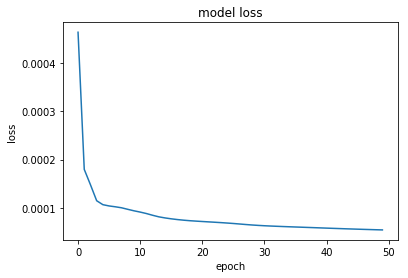

In [ ]:
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
pr = au._predict(data_set, au.autoencoder, batch_size=5)

In [ ]:
import sklearn.metrics
ds = np.concatenate(data_set)
p = np.concatenate(pr)
print (sklearn.metrics.r2_score(ds, p))
print (sklearn.metrics.mean_absolute_error(ds, p))
print (sklearn.metrics.mean_squared_error(ds, p))

0.7903188112826645
5.51843182501989e-06
9.424021464310759e-09


(58, 302000)
(58, 100)


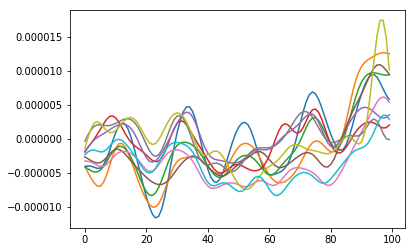

In [8]:
timestamps = 100
channels = 10

h5_fname = clear_data_path + "zavrin_open_eyes_eeg_15021500_processed.h5"
raw = h5py.File(h5_fname, 'r')
a_group_key = list(raw.keys())[0]
eeg_data = np.array(raw[a_group_key])
print(eeg_data.shape)
eeg_part = eeg_data[:, :timestamps]
print(eeg_part.shape)
for i in eeg_part[:channels]:
    plt.plot(i)
plt.show()

(58, 100)


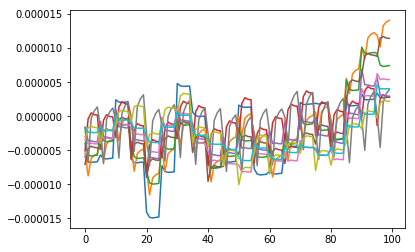

In [9]:
sample = eeg_part.T
batch_sample = au._getBatches(sample, batch_size=au.input_dim[0])
pred_sample = au._predict(batch_sample, au.autoencoder, batch_size=1)
pred_sample = np.concatenate(pred_sample).T
print(pred_sample.shape)
for i in pred_sample[:channels]:
    plt.plot(i)
plt.show()

In [ ]:
au.save("./modellstm_and_conv/au")
au.save("./modellstm_and_conv/en")
au.save("./modellstm_and_conv/de")
au.save("./modellstm_and_conv/class")